In [8]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    print(np.array(data['target']))
    print(data['target'][0])
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('Datasets/dogImages/train')
valid_files, valid_targets = load_dataset('Datasets/dogImages/valid')
test_files, test_targets = load_dataset('Datasets/dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("Datasets/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

[94 56 87 ... 28 45 47]
94
[114  95   4 113  58 132  10  30  22  53   1  24  99  19  82  55  86  57
  21  57  69  95  94  35 131 113  76 120  97  92  55  56  97  28  47  14
  19   3  69  68  58   7  89  20   1  87 109  90  14 103  82 129  33 129
  71  93 122  87  32  40  98 113  27  81  36  74  63 132  39  89  70 102
  84 114  28  97  22  96  75  98  33  60  38  15  67  83   5  48  42  76
  71 118 114  37  49  60  73  36  11  78  44 122  23  20  47  56  35  73
  72  71  11  10  19  35  28  44 112   0  50   0  34 110  51  88  48  31
  37  41  70  68  45  49  20  62  79  39 117  51  67  35  43  50   5   2
  70 127 102   6 125 112  16 118  29   1  75   9  38  38  99  28  44 104
  47   0 131 123 124 130  74 121 119  64 101  62 125 118  40  66 102  52
  10   6 131  86  91  15   4  35   6  70 119  70  43  65 102  10   8  99
   6  51  42  37  73  94 130   4  76 119  30  16   1  21  72  84  17  51
  25  53  33  13 114 103  32 122 125  73  47  91  85  34  97  45  80  37
   2  84  56  59  43  95

In [10]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/home/gtx/GitHub/Deep-Learning/DogBreedCNN/Datasets/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


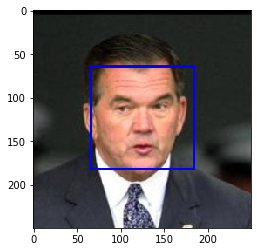

In [11]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [12]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [13]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 117s 1us/step


In [14]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [15]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [16]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [18]:
nr_files = 100

human_files_short = human_files[:nr_files]
dog_files_short = train_files[:nr_files]

human_as_human_pct = 100*sum([face_detector(image) for image in human_files_short])/nr_files
dog_as_human_pct = 100*sum([face_detector(image) for image in dog_files_short])/nr_files

print(f"Percentage of 100 first images humans detected as a human: {human_as_human_pct} %")
print(f"Percentage of 100 first images dogs detected as a human: {dog_as_human_pct} %")

human_as_dog_pct = 100*sum([dog_detector(image) for image in human_files_short])/nr_files
dog_as_dog_pct = 100*sum([dog_detector(image) for image in dog_files_short])/nr_files

print(f"Percentage of 100 first images humans detected as a dog: {human_as_dog_pct} %")
print(f"Percentage of 100 first images dogs detected as a dog: {dog_as_dog_pct} %")

Percentage of 100 first images humans detected as a human: 100.0 %
Percentage of 100 first images dogs detected as a human: 12.0 %
Percentage of 100 first images humans detected as a dog: 2.0 %
Percentage of 100 first images dogs detected as a dog: 100.0 %


In [19]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:04<00:00, 180.06it/s]


In [22]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [23]:
def original_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=train_tensors.shape[1:]))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(len(dog_names), activation='softmax'))
    
    return model

In [24]:
def original_model():
    model = Sequential()
    model.add(Conv2D(filters=1, kernel_size=2, padding='same', activation='relu', input_shape=train_tensors.shape[1:]))
    model.add(MaxPooling2D(pool_size=4))
    model.add(Conv2D(filters=1, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=4))
    model.add(Conv2D(filters=1, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=4))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(len(dog_names), activation='softmax'))
    
    return model

In [25]:
def cifar10_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=train_tensors.shape[1:]))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(len(dog_names), activation='softmax'))
    
    return model

In [ ]:
def cifar10_double_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=train_tensors.shape[1:]))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))    
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(len(dog_names), activation='softmax'))
    
    return model

In [26]:
def cifar10_double_extra_layer_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=train_tensors.shape[1:]))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(len(dog_names), activation='softmax'))
    
    return model

In [29]:
def cifar10_double_extra_layer_w_gap_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=train_tensors.shape[1:]))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(len(dog_names), activation='softmax'))

    return model

In [30]:
models = {
          "original_model": {"model": original_model},
          "cifar10_model": {"model": cifar10_model},
          "cifar10_double_extra_layer_model": {"model": cifar10_double_extra_layer_model},
          "cifar10_double_extra_layer_w_gap_model": {"model": cifar10_double_extra_layer_w_gap_model}
         }

In [32]:
from keras.preprocessing.image import ImageDataGenerator

# Here following https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [33]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
import time
# From https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [37]:
! pip install pathlib


     |████████████████████████████████| 51kB 107kB/s eta 0:00:01
  Created wheel for pathlib: filename=pathlib-1.0.1-cp36-none-any.whl size=14348 sha256=1194720a5c44c708eb41449464387707286b86128746bbda19807c85fa1bd2ff
  Stored in directory: /home/gtx/.cache/pip/wheels/f9/b2/4a/68efdfe5093638a9918bd1bb734af625526e849487200aa171
Successfully built pathlib


In [38]:
import pathlib
def train_models(models, train_data, valid_data, augment, epochs, batch_size):
    for key in models.keys():
        print(f"\n\nNow processing the {key}")
        model = models[key]["model"]()
        filepath = pathlib.Path(".").absolute().joinpath('saved_models',f'weights.best.{key}.hdf5')
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

        checkpointer = ModelCheckpoint(filepath=str(filepath), verbose=1, save_best_only=True)

        time_callback = TimeHistory()

        if augment:
            history = model.fit_generator(datagen.flow(train_data, train_targets, batch_size=batch_size),
                                          steps_per_epoch=train_data.shape[0] // batch_size,
                                          validation_data=(valid_data, valid_targets),
                                          validation_steps=valid_data.shape[0] // batch_size,
                                          epochs=epochs, callbacks=[checkpointer, time_callback], verbose=2)
        else:
            history = model.fit(train_tensors, train_targets, 
                                validation_data=(valid_tensors, valid_targets),
                                epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, time_callback], verbose=2)

        models[key]["time"] = time_callback.times
        models[key]["history"] = dict(epoch=history.epoch, 
                                      loss=history.history["loss"],
                                      acc=history.history["acc"], 
                                      val_loss=history.history["val_loss"],
                                      val_acc=history.history["val_acc"])
        
    return models

In [40]:
models = train_models(models=models, train_data=train_tensors, valid_data=valid_tensors, augment=True, epochs=10, batch_size=20)



Now processing the original_model
Epoch 1/10
 - 54s - loss: 4.8879 - acc: 0.0094 - val_loss: 4.8837 - val_acc: 0.0108

Epoch 00001: val_loss improved from inf to 4.88373, saving model to /home/gtx/GitHub/Deep-Learning/DogBreedCNN/saved_models/weights.best.original_model.hdf5
Epoch 2/10
 - 53s - loss: 4.8811 - acc: 0.0100 - val_loss: 4.8790 - val_acc: 0.0108

Epoch 00002: val_loss improved from 4.88373 to 4.87901, saving model to /home/gtx/GitHub/Deep-Learning/DogBreedCNN/saved_models/weights.best.original_model.hdf5
Epoch 3/10
 - 53s - loss: 4.8763 - acc: 0.0115 - val_loss: 4.8755 - val_acc: 0.0108

Epoch 00003: val_loss improved from 4.87901 to 4.87549, saving model to /home/gtx/GitHub/Deep-Learning/DogBreedCNN/saved_models/weights.best.original_model.hdf5
Epoch 4/10
 - 54s - loss: 4.8727 - acc: 0.0115 - val_loss: 4.8730 - val_acc: 0.0108

Epoch 00004: val_loss improved from 4.87549 to 4.87300, saving model to /home/gtx/GitHub/Deep-Learning/DogBreedCNN/saved_models/weights.best.orig


Epoch 00007: val_loss improved from 4.86894 to 4.86888, saving model to /home/gtx/GitHub/Deep-Learning/DogBreedCNN/saved_models/weights.best.cifar10_double_extra_layer_w_gap_model.hdf5
Epoch 8/10
 - 55s - loss: 4.8657 - acc: 0.0112 - val_loss: 4.8691 - val_acc: 0.0108

Epoch 00008: val_loss did not improve from 4.86888
Epoch 9/10
 - 54s - loss: 4.8658 - acc: 0.0112 - val_loss: 4.8691 - val_acc: 0.0108

Epoch 00009: val_loss did not improve from 4.86888
Epoch 10/10
 - 55s - loss: 4.8655 - acc: 0.0114 - val_loss: 4.8688 - val_acc: 0.0108

Epoch 00010: val_loss improved from 4.86888 to 4.86879, saving model to /home/gtx/GitHub/Deep-Learning/DogBreedCNN/saved_models/weights.best.cifar10_double_extra_layer_w_gap_model.hdf5


In [41]:
def get_accuracy(models, test_data):
    for key in models.keys():
        model = models[key]["model"]()

        # Load the Model with the Best Validation Loss
        filepath = pathlib.Path(".").absolute().joinpath('saved_models', f'weights.best.{key}.hdf5')
        model.load_weights(str(filepath))

        # get index of predicted dog breed for each image in test set
        dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_data]

        # report test accuracy
        models[key]["test_accuracy"] = \
            100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
            
    return models

In [42]:
models = get_accuracy(models, test_tensors)


In [43]:
import pickle

# Pickling the model in case of unexpected error
with open("models.pickle", "wb") as f:
    pickle.dump(models, f)

In [44]:
with open("models.pickle", "rb") as f:
    models = pickle.load(f)

In [45]:
def plot_stats(models):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(12, 12))

    for key in models.keys():
        ax1.plot(models[key]["history"]["epoch"], 
                 models[key]["history"]["val_loss"],
                 label=f"{key}, test_acc = {models[key]['test_accuracy']:.4}%")
        ax2.plot(models[key]["history"]["epoch"],
                 models[key]["history"]["val_acc"])
        ax3.plot(models[key]["history"]["epoch"], 
                 models[key]["history"]["loss"])
        ax4.plot(models[key]["history"]["epoch"],
                 models[key]["history"]["acc"])
        ax5.plot(models[key]["history"]["epoch"],
                 models[key]["time"])

    _ = ax1.set_ylabel("val_loss")
    ax1.grid(True)
    _ = ax1.legend()
    _ = ax2.set_ylabel("val_acc")
    ax2.grid(True)
    _ = ax3.set_ylabel("train_loss")
    ax3.grid(True)
    _ = ax4.set_ylabel("train_acc")
    ax4.grid(True)
    _ = ax5.set_ylabel("Epoch calculation time [s]")
    _ = ax5.set_xlabel("epoch")
    ax5.grid(True)
    plt.show()

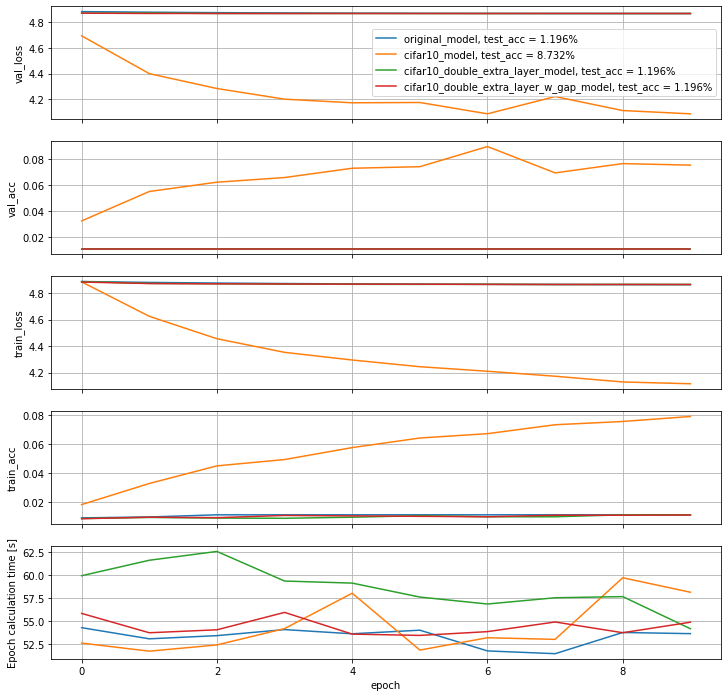

In [46]:
plot_stats(models)


In [ ]:
# /home/gtx/Downloads

In [47]:
bottleneck_features = np.load('/home/gtx/Downloads/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [48]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [49]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [51]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
                validation_data=(valid_VGG16, valid_targets),
                epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s 121us/step - loss: 8.6214 - acc: 0.3353 - val_loss: 8.5869 - val_acc: 0.3449

Epoch 00001: val_loss improved from inf to 8.58686, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 120us/step - loss: 7.8842 - acc: 0.4135 - val_loss: 8.1900 - val_acc: 0.3808

Epoch 00002: val_loss improved from 8.58686 to 8.19002, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 1s 122us/step - loss: 7.4421 - acc: 0.4620 - val_loss: 7.8658 - val_acc: 0.3988

Epoch 00003: val_loss improved from 8.19002 to 7.86577, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 123us/step - loss: 6.9225 - acc: 0.5085 - val_loss: 7.4662 - val_acc: 0.4335

Epoch 00004: val_loss improved from 7.86577 to 7.46619, saving model to saved_mode

In [52]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')


In [53]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 53.5885%


In [54]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]